# **Deep Q learning - MountainCar environment**
[Deep Q learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) agent to solve the [MountainCar](https://gym.openai.com/envs/MountainCar-v0/) environment. <br>
Rewritten to use the [TRFL](https://github.com/deepmind/trfl) library based on: 
https://medium.com/aureliantactics/basic-trfl-usage-ad2a7e1afdde <br>
The code below was written and tested in Colab notebook.

# 1. Training

In [0]:
# TRFL requires older tensorflow 1.12.0
!pip install tensorflow==1.12 > /dev/null 2>&1 # suppress stdout
# Install TRFL
!pip install trfl > /dev/null 2>&1 # suppress stdout

In [2]:
import gym
import tensorflow as tf
import trfl
import numpy as np
from collections import deque

# Training parameters
train_episodes = 4000
max_steps = 200
gamma = 0.99  # discount factor

# Exploration parameters
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay_rate = 0.00001

# Q-Network parameters
hidden_size = 64
learning_rate = 0.0001

# Memory parameters
memory_size = 10000
batch_size = 20
pretrain_length = batch_size

np.random.seed(37)


class DQNet:
    """Deep Q Network"""
    def __init__(self, state_size, action_size, learning_rate=0.01, hidden_size=10, name='DQNet'):
        with tf.variable_scope(name):
            # Input
            self.inputs = tf.placeholder(tf.float32, [None, state_size], name='inputs')
                       
            # Layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, activation_fn=None)
            
            # Commented out => prior to TRFL
#             # Output and target
#             self.actions = tf.placeholder(tf.int32, [None], name='actions')
#             one_hot_actions = tf.one_hot(self.actions, action_size)
#             self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
#             self.targetQ = tf.placeholder(tf.float32, [None], name='target')
            
#             # Minimize mean squared error between target Q and current Q
#             self.loss = tf.reduce_mean(tf.square(self.targetQ - self.Q))
#             self.optimize = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
            
            self.actions = tf.placeholder(tf.int32, [None], name='actions')
            self.targetQ = tf.placeholder(tf.float32, [batch_size, action_size], name='target')
            self.reward = tf.placeholder(tf.float32, [batch_size], name='reward')
            self.discount = tf.constant(gamma, tf.float32, [batch_size], name='discount')
            
            q_loss, q_learning = trfl.qlearning(self.output, self.actions, self.reward, self.discount, self.targetQ)
            self.loss = tf.reduce_mean(q_loss)
            self.optimize = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

            
class Experience:
    """Memory that stores past experinces: <s, a, r, s'>"""
    def __init__(self, max_size=1000):
        self.memory = deque(maxlen=max_size)
    def add(self, experience):
        self.memory.append(experience)
    def sample(self, batch_size):
        idxs = np.random.choice(len(self.memory), size=batch_size, replace=False)
        return [self.memory[i] for i in idxs]
    
    
env = gym.make('MountainCar-v0')
print(f"Observation space size: {env.observation_space.shape} Action space size: {env.action_space.n}")
tf.reset_default_graph()
main_dqn = DQNet(name='main', state_size=env.observation_space.shape[0], action_size=env.action_space.n, 
                 hidden_size=hidden_size, learning_rate=learning_rate)
experience = Experience(max_size=memory_size)

# Populate the experience memory, using random actions
s = env.reset()
for i in range(pretrain_length):
  
    a = env.action_space.sample()
    next_s, r, done, _ = env.step(a)
    
    if done:
        # No next state when the episode ended
        next_s = np.zeros(s.shape)
        experience.add((s, a, r, next_s))
        # Start new episode
        s = env.reset()
    else:
        experience.add((s, a, r, next_s))
        s = next_s
        
# Train
saver = tf.train.Saver()
total_rewards = []
with tf.Session() as sess:
    steps = 0
    sess.run(tf.global_variables_initializer())
    for episode in range(train_episodes):
        s = env.reset()
        episode_reward = 0
        t = 0
        while t < max_steps:
            t += 1
            # Uncomment to watch the training
#             env.render()
            
            # Update epsilon
            epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-steps * epsilon_decay_rate)
            steps += 1
            # epsilon-greedy choice of action
            if np.random.rand() < epsilon:
                a = env.action_space.sample()
            else:
                Q = sess.run(main_dqn.output, feed_dict={main_dqn.inputs: np.expand_dims(s, axis=0)})
                a = np.argmax(Q)
            
            next_s, r, done, _ = env.step(a)          
            episode_reward += r
            
            if done:
                total_rewards.append(episode_reward)
                # No next state when the episode ended
                next_s = np.zeros(s.shape)
                experience.add((s, a, r, next_s))
                print(f"Episode: {episode} Episode reward: {episode_reward} Training loss: {loss} Epsilon: {epsilon}")
                t = max_steps # end of this episode
            else:
                experience.add((s, a, r, next_s))
                s = next_s
        
            # Experience replay & train
            batch = experience.sample(batch_size)
            states = np.array([e[0] for e in batch])
            actions = np.array([e[1] for e in batch])
            rewards = np.array([e[2] for e in batch])
            next_states = np.array([e[3] for e in batch])
            # Predict targets
            targetQ = sess.run(main_dqn.output, feed_dict={main_dqn.inputs: next_states})
            # Set targets to zero where an episode ended
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            targetQ[episode_ends] = (0, ) * env.action_space.n
            
            # Commented out => prior to TRFL
#             targetQ = rewards + gamma * np.max(targetQ, axis=1)
#             loss, _ = sess.run([main_dqn.loss, main_dqn.optimize], feed_dict={
#                 main_dqn.inputs: states,
#                 main_dqn.targetQ: targetQ,
#                 main_dqn.actions: actions
#             })
            loss, _ = sess.run([main_dqn.loss, main_dqn.optimize], feed_dict={
                main_dqn.inputs: states,
                main_dqn.targetQ: targetQ,
                main_dqn.reward: rewards, 
                main_dqn.actions: actions
            })
        
    saver.save(sess, 'checkpoints/dqn_mountaincar.ckpt')

Observation space size: (2,) Action space size: 3
Episode: 0 Episode reward: -200.0 Training loss: 0.3620566725730896 Epsilon: 0.998111379800359
Episode: 1 Episode reward: -200.0 Training loss: 0.3359779715538025 Epsilon: 0.9962170520000012
Episode: 2 Episode reward: -200.0 Training loss: 0.2538033425807953 Epsilon: 0.9943265090691131
Episode: 3 Episode reward: -200.0 Training loss: 0.15705643594264984 Epsilon: 0.9924397434455202
Episode: 4 Episode reward: -200.0 Training loss: 0.24562378227710724 Epsilon: 0.9905567475821578
Episode: 5 Episode reward: -200.0 Training loss: 0.14529390633106232 Epsilon: 0.9886775139470397
Episode: 6 Episode reward: -200.0 Training loss: 0.09067398309707642 Epsilon: 0.986802035023229
Episode: 7 Episode reward: -200.0 Training loss: 0.13847504556179047 Epsilon: 0.9849303033088076
Episode: 8 Episode reward: -200.0 Training loss: 0.18733438849449158 Epsilon: 0.9830623113168458
Episode: 9 Episode reward: -200.0 Training loss: 0.0840718001127243 Epsilon: 0.981

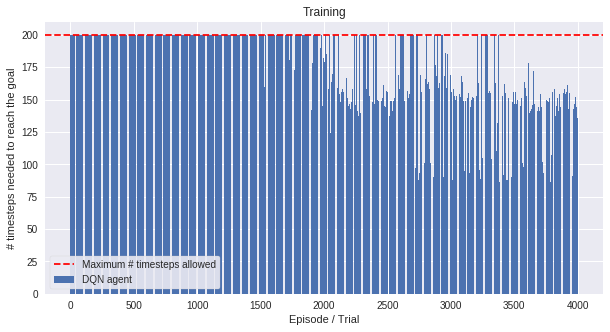

In [22]:
# Show training progress

import matplotlib.pyplot as plt
timesteps_to_goal = -1 * np.array(total_rewards)

plt.figure(figsize=(10, 5))
plt.title('Training')
plt.bar(range(len(timesteps_to_goal)), timesteps_to_goal, label='DQN agent')
plt.axhline(200, c='r', linestyle='--', label='Maximum # timesteps allowed')
plt.xlabel('Episode / Trial')
plt.ylabel('# timesteps needed to reach the goal')
plt.legend(loc='lower left', fancybox=True, frameon=True, framealpha=0.9)
plt.show()


# 2. Evaluation

In [0]:
# To render the environment within the Colab notebook and then save as GIF animation
# Adapted from: https://colab.research.google.com/drive/16gZuQlwxmxR5ZWYLZvBeq3bTdFfb1r_6#scrollTo=6L4YayzR4FYj&forceEdit=true&offline=true&sandboxMode=true

!apt-get install -y xvfb python-opengl > /dev/null 2>&1 # suppress stdout
!pip install gym pyvirtualdisplay > /dev/null 2>&1 # suppress stdout

from PIL import Image, ImageDraw
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()


In [40]:
# Test
test_episodes = 10
test_max_steps = 200
total_test_rewards = []
frames = []

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))

    for episode in range(test_episodes):
        episode_reward = 0
        t = 0
        
        s = env.reset()
        frame = Image.fromarray(env.render(mode='rgb_array'))
        ImageDraw.Draw(frame).text((220, 20), f"Episode: {episode} Timestep: {t}", (70, 70, 70))
        frames.append(frame)
        
        while t < test_max_steps: 
            # Take action 
            Q = sess.run(main_dqn.output, feed_dict={main_dqn.inputs: np.expand_dims(s, axis=0)})
            a = np.argmax(Q)
            next_s, r, done, _ = env.step(a)
            episode_reward += r
            t += 1

            # Render to array and store
            frame = Image.fromarray(env.render(mode='rgb_array'))
            ImageDraw.Draw(frame).text((220, 20), f"Episode: {episode} Timestep: {t}", (70, 70, 70))
            frames.append(frame)
            
            if done:
                total_test_rewards.append(episode_reward)
                print(f"Episode: {episode} Episode reward: {episode_reward}")
                # Show episode result
                text_result = "Success!" if t < test_max_steps else "Timeout!"
                for i in range(50):
                    frame1 = frame.copy()
                    ImageDraw.Draw(frame1).text((220, 40 + i), text_result, (200, 0, 0))
                    frames.append(frame1)
                break
            else:
                s = next_s

# Tear down rendering
display.stop()


INFO:tensorflow:Restoring parameters from checkpoints/dqn_mountaincar.ckpt
Episode: 0 Episode reward: -90.0
Episode: 1 Episode reward: -145.0
Episode: 2 Episode reward: -87.0
Episode: 3 Episode reward: -146.0
Episode: 4 Episode reward: -86.0
Episode: 5 Episode reward: -143.0
Episode: 6 Episode reward: -93.0
Episode: 7 Episode reward: -141.0
Episode: 8 Episode reward: -143.0
Episode: 9 Episode reward: -89.0


In [0]:
# Save all frames as GIF animation and download

from google.colab import files
frames[0].save('dql_test_mountaincar.gif', format='GIF', append_images=frames[1:], save_all=True, loop=0) #, optimize=False)#, duration=10*test_episodes, loop=0, optimize=False)
files.download('dql_test_mountaincar.gif')


In [42]:
# Compare with baseline: random choice of actions

baseline_total_test_rewards = []
for episode in range(test_episodes):
    episode_reward = 0
    t = 0
    s = env.reset()
    while t < test_max_steps:
        t += 1
        # Take random action 
        a = env.action_space.sample()
        next_s, r, done, _ = env.step(a)
        episode_reward += r

        if done:
            baseline_total_test_rewards.append(episode_reward)
            print(f"Episode: {episode} Episode reward: {episode_reward}")
            break
        else:
            s = next_s
            

Episode: 0 Episode reward: -200.0
Episode: 1 Episode reward: -200.0
Episode: 2 Episode reward: -200.0
Episode: 3 Episode reward: -200.0
Episode: 4 Episode reward: -200.0
Episode: 5 Episode reward: -200.0
Episode: 6 Episode reward: -200.0
Episode: 7 Episode reward: -200.0
Episode: 8 Episode reward: -200.0
Episode: 9 Episode reward: -200.0


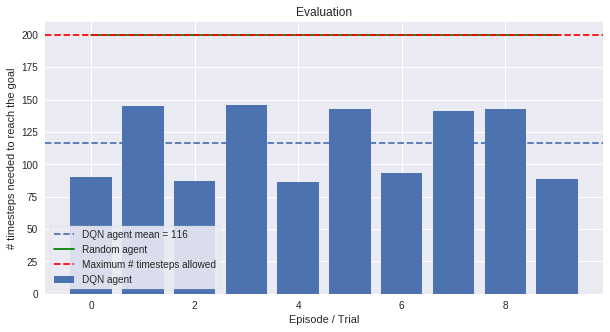

In [46]:
# Show testing results

timesteps_to_goal = -1 * np.array(total_test_rewards)
baseline_timesteps_to_goal = -1 * np.array(baseline_total_test_rewards)

plt.figure(figsize=(10, 5))
plt.title('Evaluation')
plt.bar(range(len(timesteps_to_goal)), timesteps_to_goal, label='DQN agent')
# plt.plot(timesteps_to_goal, label='DQN agent')
plt.axhline(np.mean(timesteps_to_goal), linestyle='--', label=f'DQN agent mean = {int(np.mean(timesteps_to_goal))}')
plt.plot(baseline_timesteps_to_goal, c='g', label='Random agent')
plt.axhline(200, c='r', linestyle='--', label='Maximum # timesteps allowed')
plt.xlabel('Episode / Trial')
plt.ylabel('# timesteps needed to reach the goal')
# plt.legend()
plt.legend(loc='lower left', fancybox=True, frameon=True, framealpha=0.9)
# plt.legend(bbox_to_anchor=(1.0, 0.7))
plt.show()
